In [4]:
import pandas as pd
df = pd.read_csv("/Users/mingliangang/Desktop/Quora_Data/train.csv")
print(df.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [8]:
from sklearn.metrics import log_loss
import numpy as np
p = df['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df['is_duplicate'], np.zeros_like(df['is_duplicate']) + p))

df_test = pd.read_csv('/Users/mingliangang/Desktop/Quora_Data/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

Predicted score: 0.658527383984


,is_duplicate,test_id
0,0.369198,0
1,0.369198,1
2,0.369198,2
3,0.369198,3
4,0.369198,4


# Word Matching

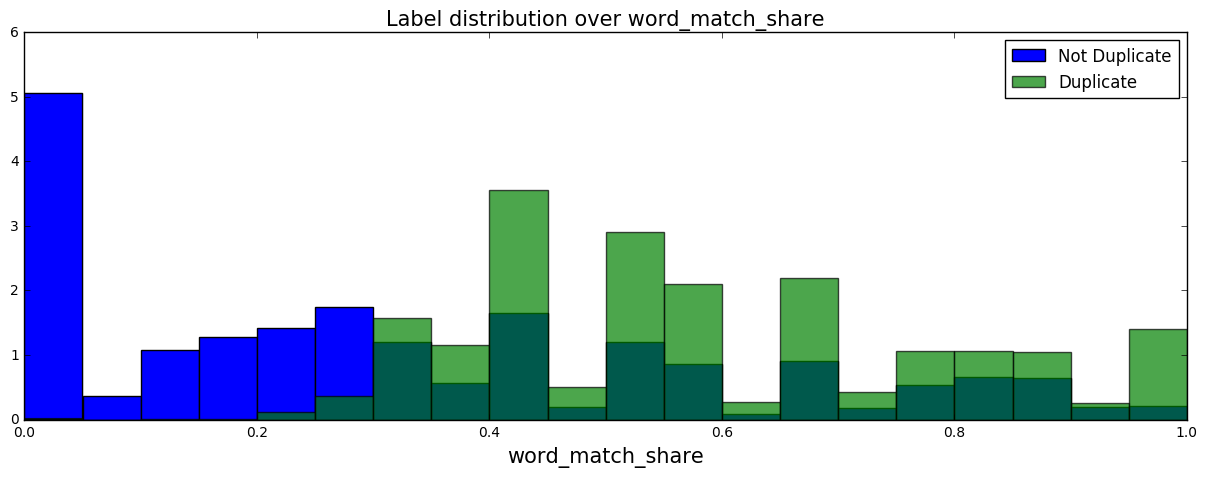

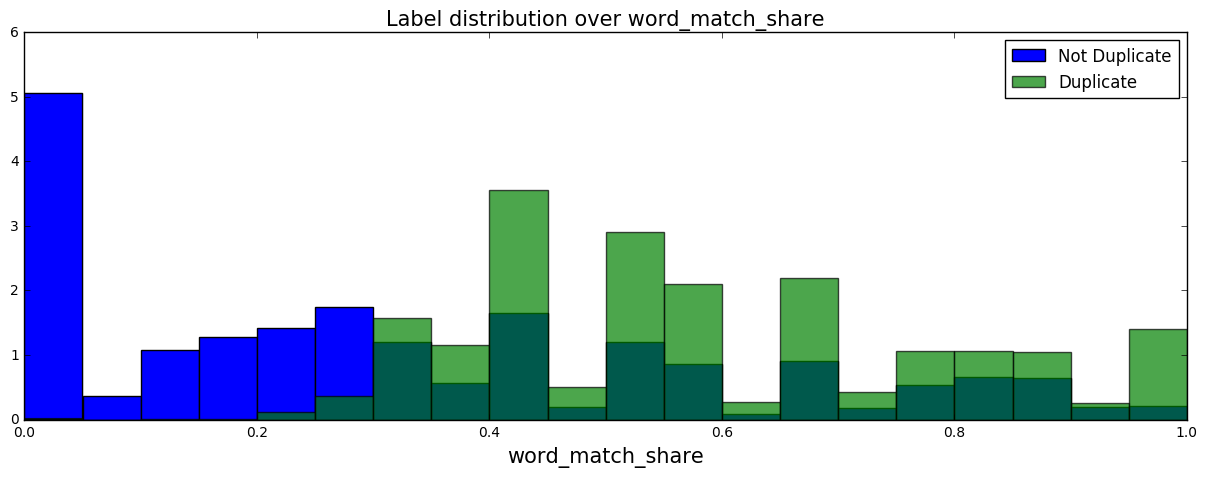

In [14]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.show()

# TF-IDF

In [17]:
from collections import Counter

train_qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [18]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [21]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [23]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.780553200628
   TFIDF AUC: 0.770564793372
